In [1]:
import os
import sys
import time
import random
import numpy as np
import imgaug 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval
# from pycocotools import mask as maskUtils
import zipfile
import urllib.request
import json
import shutil
from PIL import Image, ImageDraw

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../../Mask_RCNN/")
# Import Mask RCNN
# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib
from mrcnn.model import log

Using TensorFlow backend.


In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
DEFAULT_DATASET_YEAR = "2019"

In [4]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [5]:
############################################################
#  Configurations
############################################################

class SkinConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "skin"
    
    GPU_COUNT = 2
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2
    
    LEARNING_RATE = 0.001
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + skin

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 200
    
    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 70
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # Skip detections with < 90% confidence
#     DETECTION_MIN_CONFIDENCE = 0.9
     # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
    
config = SkinConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [6]:
class SkinDataset(utils.Dataset):
    
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "skin"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
#             print(class_name)
    
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
#             print('hi')
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
#             print(image_id)
        
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
#             print(annotations)
            
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

## Creating Training and Validation Data

In [7]:
dataset_train = SkinDataset()
dataset_train.load_data('../../../Input/Skin_Datasets/Coco_format/train/instances_skin_train2019.json','../../../Input/Skin_Datasets/Coco_format/train/skin_train2019/')
dataset_train.prepare()

In [8]:
dataset_val = SkinDataset()
dataset_val.load_data('../../../Input/Skin_Datasets/Coco_format/val/instances_skin_val2019.json','../../../Input/Skin_Datasets/Coco_format/val/skin_val2019/')
dataset_val.prepare()

In [9]:
dataset_test = SkinDataset()
dataset_test.load_data('../../../Input/Skin_Datasets/Coco_format/test/test_pratheepan/instances_skin_test2019.json','../../../Input/Skin_Datasets/Coco_format/test/test_pratheepan/skin_test2019/')
dataset_test.prepare()

In [111]:
# dataset_test = SkinDataset()
# dataset_test.load_data('../../../Input/Skin_Datasets/Coco_format/test/test_abdomen/instances_skin_test2019.json','../../../Input/Skin_Datasets/Coco_format/test/test_abdomen/skin_test2019/')
# dataset_test.prepare()

In [112]:
# dataset_test = SkinDataset()
# dataset_test.load_data('../../../Input/Skin_Datasets/Coco_format/test/test_FSD/instances_skin_test2019.json','../../../Input/Skin_Datasets/Coco_format/test/test_FSD/skin_test2019/')
# dataset_test.prepare()

# Display a few images from the training dataset¶


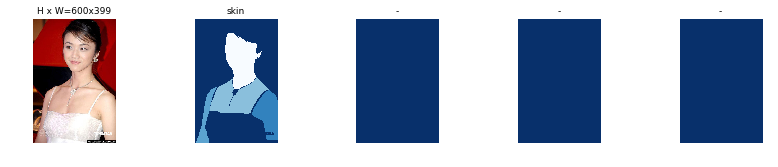

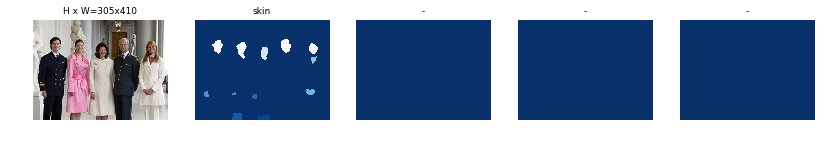

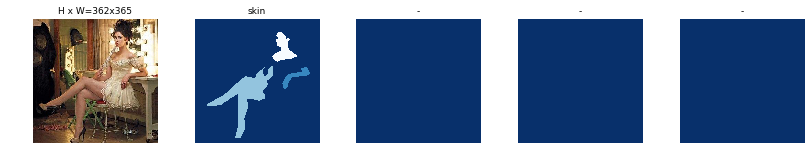

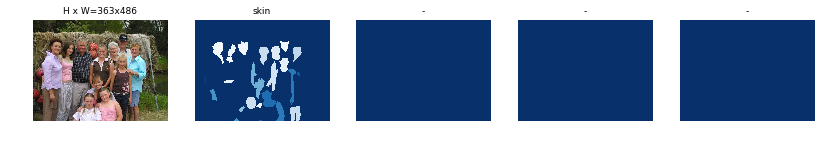

In [113]:
dataset = dataset_test
image_ids = np.random.choice(dataset.image_ids, 4)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train¶ 

In [ ]:
# # Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)



In [ ]:
# # # Which weights to start with?
# # init_with = "coco"  # imagenet, coco, or last
# init_with = "last"  # imagenet, coco, or last

# if init_with == "imagenet":
#     model.load_weights(model.get_imagenet_weights(), by_name=True)
# elif init_with == "coco":
#     # Load weights trained on MS COCO, but skip layers that
#     # are different due to the different number of classes
#     # See README for instructions to download the COCO weights
#     model.load_weights(COCO_MODEL_PATH, by_name=True,
#                        exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
#                                 "mrcnn_bbox", "mrcnn_mask"])
# elif init_with == "last":
#     # Load the last model you trained and continue training
#     model.load_weights(model.find_last(), by_name=True)
    
    
model_path = '/home/anirudh/anirudh_files/Umbilicus_Skin_Detection/Mask_RCNN/logs/mask_rcnn_skin_0064_lr_0.001.h5'
# Load trained weights (fill in path to trained weights here)
# assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Training
Train in two stages:

   * Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

   * Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.


In [ ]:
config.LEARNING_RATE

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=64, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print('Training took' + str(minutes)+ 'minutes')



In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=128, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print('Training took' + str(minutes)+ 'minutes')



# Prepare to run Inference 

In [11]:
class InferenceConfig(SkinConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [12]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

W0727 16:13:25.287297 139728683099904 deprecation_wrapper.py:119] From /home/anirudh/.env1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 16:13:25.311823 139728683099904 deprecation_wrapper.py:119] From /home/anirudh/.env1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 16:13:25.315478 139728683099904 deprecation_wrapper.py:119] From /home/anirudh/.env1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0727 16:13:25.339090 139728683099904 deprecation_wrapper.py:119] From /home/anirudh/.env1/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm inste

In [100]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()
model_path = '/home/anirudh/anirudh_files/Umbilicus_Skin_Detection/Mask_RCNN/logs/mask_rcnn_skin_0064_lr_0.0001.h5'
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/anirudh/anirudh_files/Umbilicus_Skin_Detection/Mask_RCNN/logs/mask_rcnn_skin_0064_lr_0.0001.h5


# Run Inference

In [63]:
# image_id = random.choice(dataset_test.image_ids)
# image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_test, config, image_id, use_mini_mask=False)
# info = dataset_test.image_info[image_id]
# print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                        dataset_test.image_reference(image_id)))
# # Run object detection
# results = model.detect([image], verbose=1)

# # Display results
# # ax = get_ax(1)
# # r = results[0]
# # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
# #                             dataset_test.class_names, r['scores'], ax=ax,
# #                             title="Predictions")
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)



In [64]:
# # Draw precision-recall curve
# AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                                           r['rois'], r['class_ids'], r['scores'], r['masks'])
# visualize.plot_precision_recall(AP, precisions, recalls)

In [45]:
def acc_comp_anirudh(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    mean_acc = []
    mean_prec = []
    mean_rec = []
    mean_f = []
#     tp = []
#     tn = []
#     fp=[]
#     fn=[]
    FPR = []
    TPR= []
    IMG_WIDTH = 1024
    IMG_HEIGHT = 1024
    for j in range(len(msk)):
        act = msk[j]
        pr = preds_test_t[j]
#     .reshape(IMG_WIDTH, IMG_HEIGHT)
        c = act == pr #acc
        d = act & pr #true negative
        e = act | pr #true positive
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()
    
        TN = round(float(d.sum()),6)
        FN = round(float(pr.sum()-d.sum()),6)
        TP = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FP = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)
    
        acc2 = float(TP+TN)/(TP+TN+FP+FN)
        prec = float(TP)/(TP+FP+0.0000000001)
        rec = float(TP)/(TP+FN)
        f_measure = 2*(prec*rec)/(prec+rec+0.0000000001)
        tpr = float(TP)/(TP+FN)
        fpr = float(FP)/(FP+TN)
        
        mean_acc.append(acc2)
        mean_prec.append(prec)
        mean_rec.append(rec)
        mean_f.append(f_measure)
        TPR.append(tpr)
        FPR.append(fpr)
        
#         tp.append(TP)
#         tn.append(TN)
#         fp.append(FP)
#         fn.append(FN)
        
        
    return mean_acc, mean_prec ,mean_rec, mean_f,TPR,FPR #tp ,tn, fp,fn

In [114]:
# Compute VOC-style Average Precision
c=0
negimages = []
ori=[]
msk=[]
pred=[]
for image_id in dataset_test.image_ids:
    # Load image
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    ## Visualizing results for each image
#     maskpre= visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#       
#     Counting Numper of Images where there are no predictions
    if (r['rois'].shape[0]==0):
        c= c+1
        negimages.append(image)
        continue
    maskpre=  r['masks'][:,:,0]
#     break
#     acc = np.sum(gt_mask[:,:,0] == maskpre)/np.size(maskpre)
#     print(acc)
#     accu.append(acc)
    
    ori.append(image)
    msk.append(gt_mask[:,:,0])
    pred.append(maskpre)
    
#     plt.close()
    
# print("mean accu = "+str(np.mean(accu)))
    


In [115]:
print("Number of no detections", c)

Number of no detections 14


In [116]:
# Overall accuracy on abdomen pictures
mean_accu, mean_prec,mean_rec, mean_f, TPR,FPR = acc_comp_anirudh(msk, pred);

avg = np.mean(mean_accu)
std = np.std(mean_accu)
precision = np.mean(mean_prec)
recall = np.mean(mean_rec)
fmeasure = np.mean(mean_f)
print("Accuracy " + str(avg))
print("STD Deviation " + str(std))
print("Precision " + str(precision))
print("Recall " + str(recall))
print("F-Measure " + str(fmeasure))


Accuracy 0.9540784358978271
STD Deviation 0.04541196602968746
Precision 0.9790837773215504
Recall 0.969522819639582
F-Measure 0.9735612641439693


## Positive Predictions

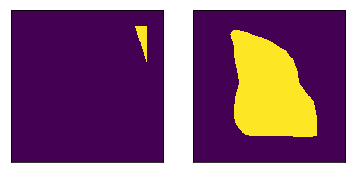

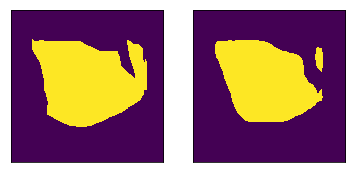

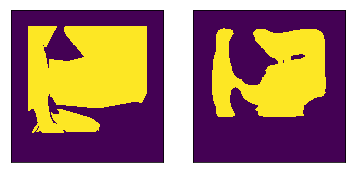

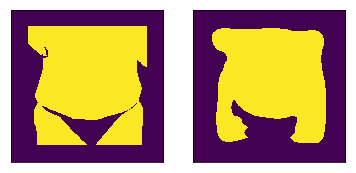

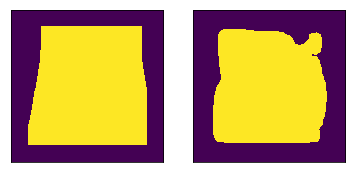

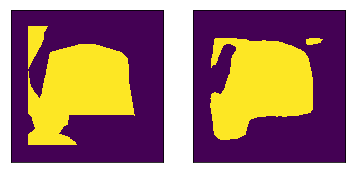

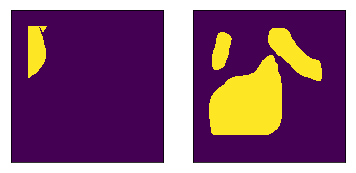

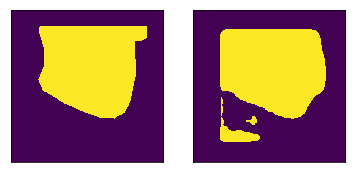

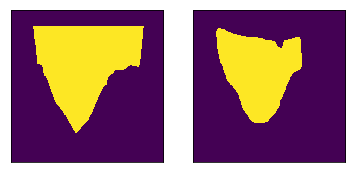

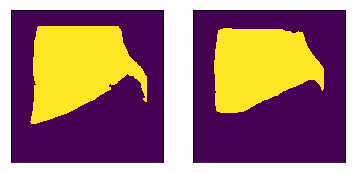

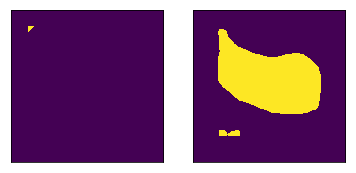

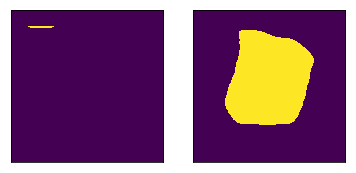

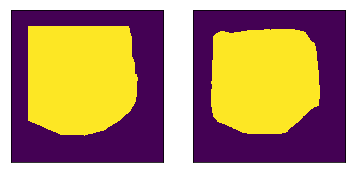

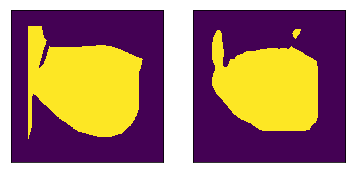

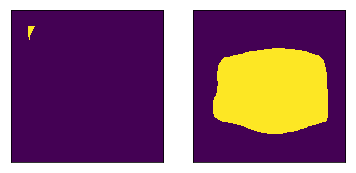

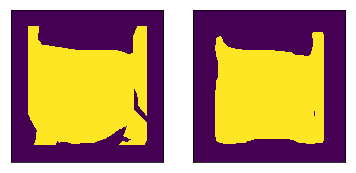

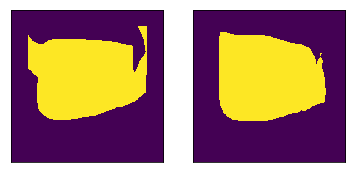

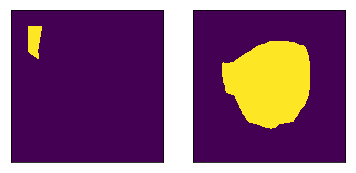

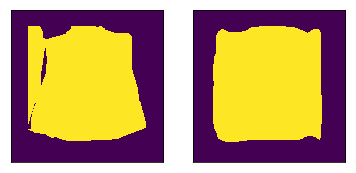

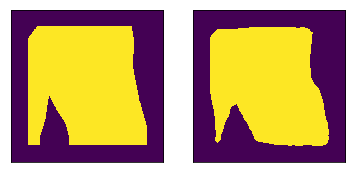

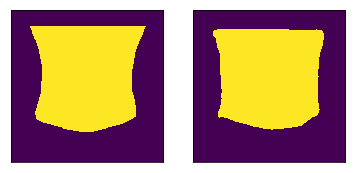

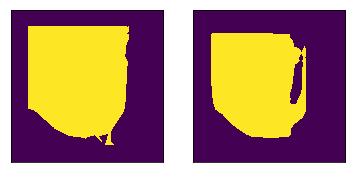

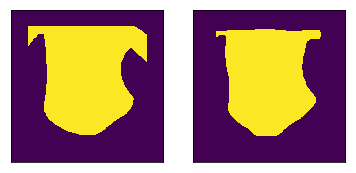

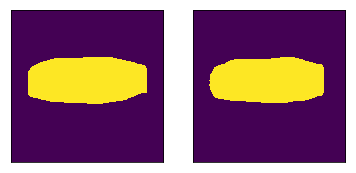

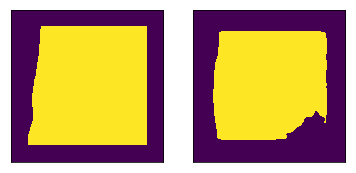

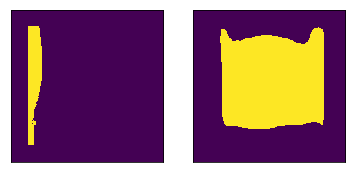

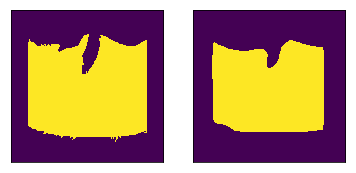

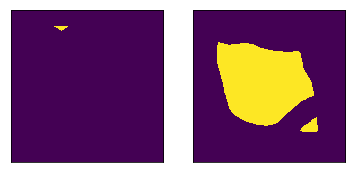

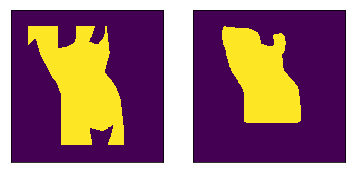

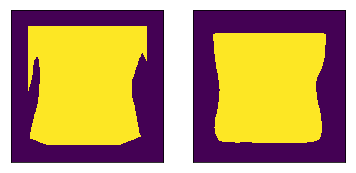

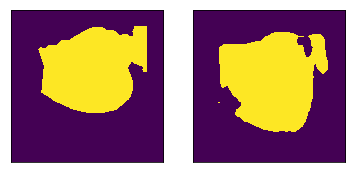

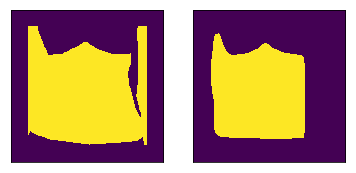

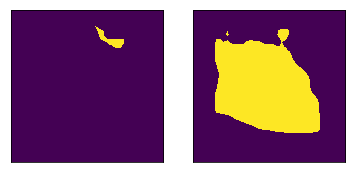

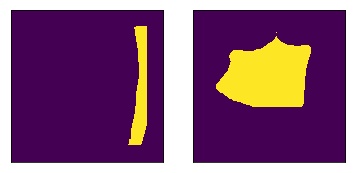

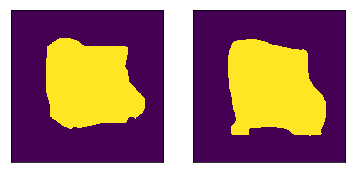

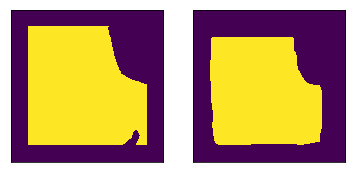

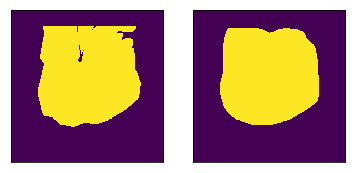

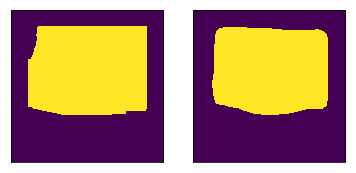

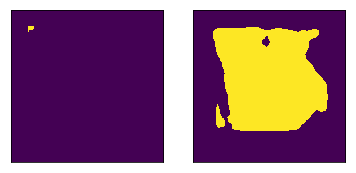

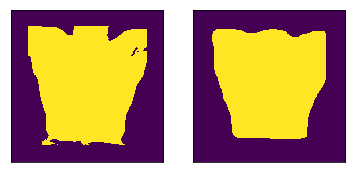

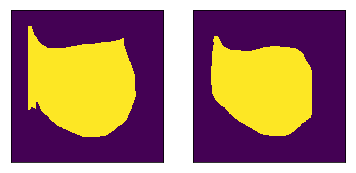

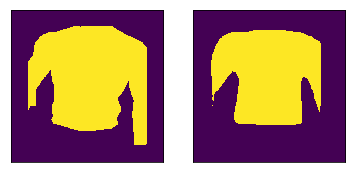

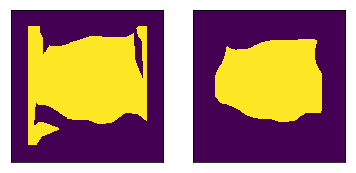

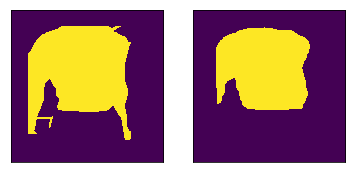

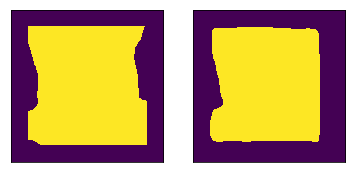

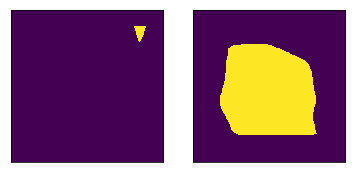

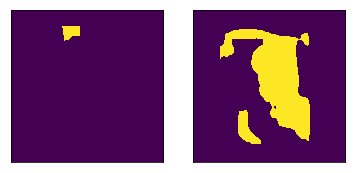

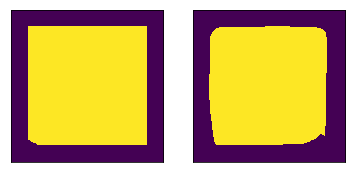

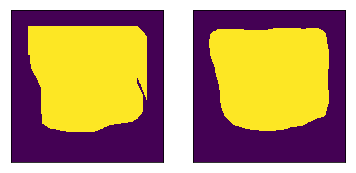

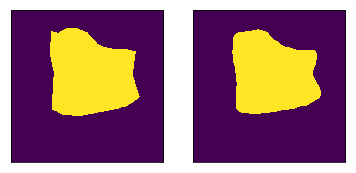

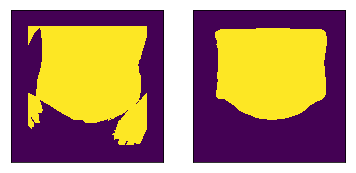

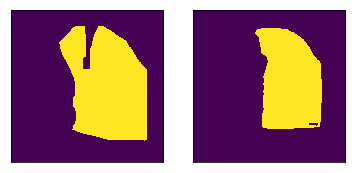

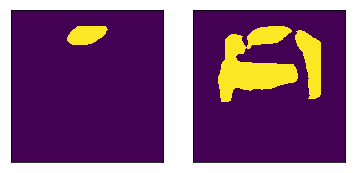

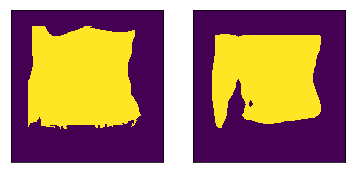

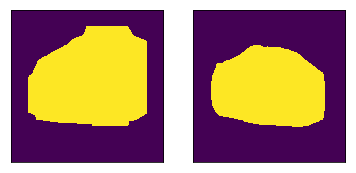

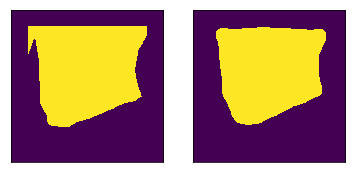

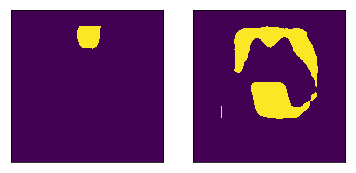

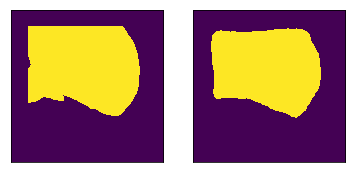

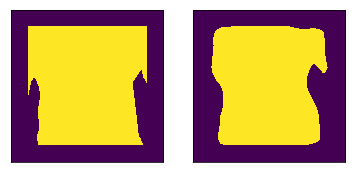

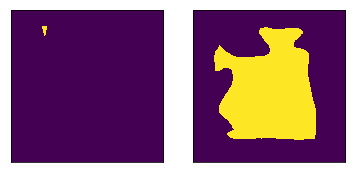

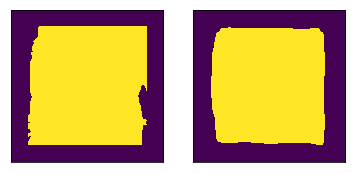

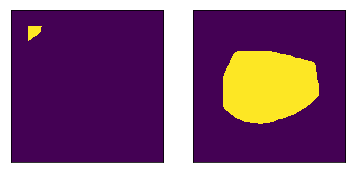

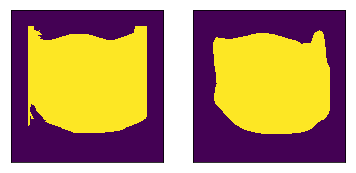

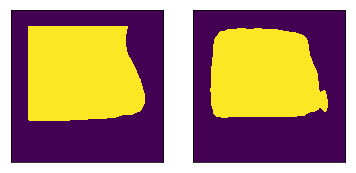

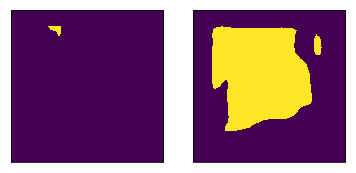

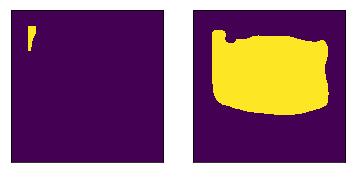

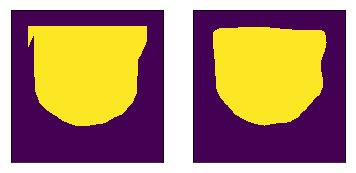

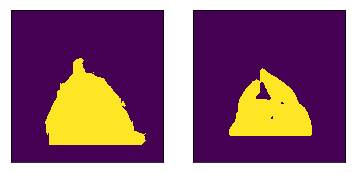

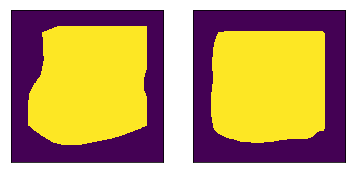

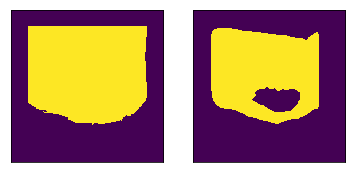

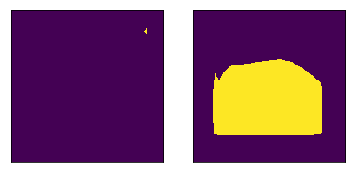

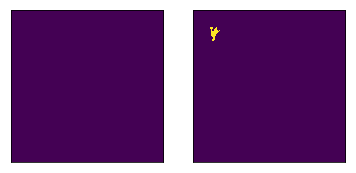

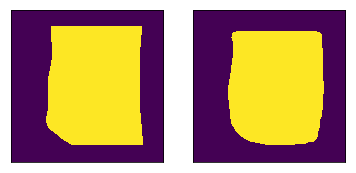

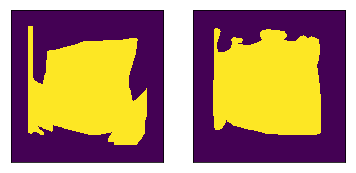

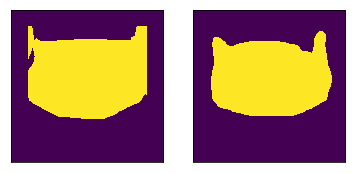

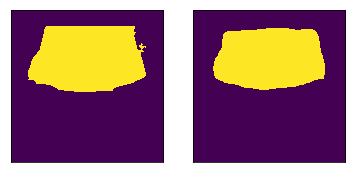

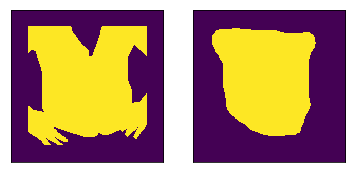

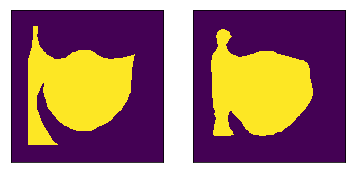

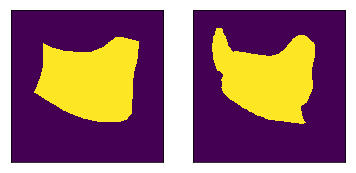

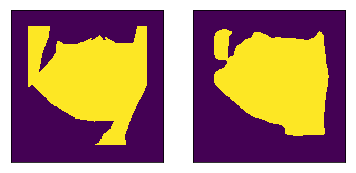

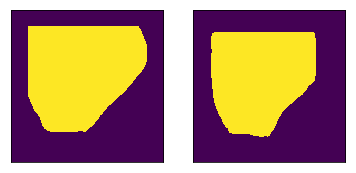

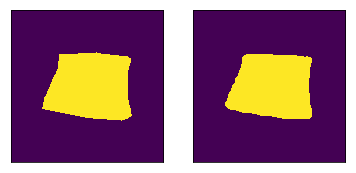

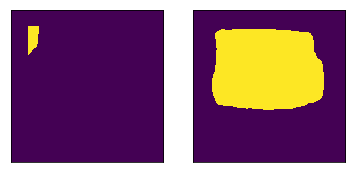

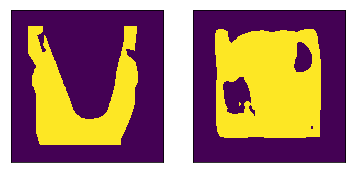

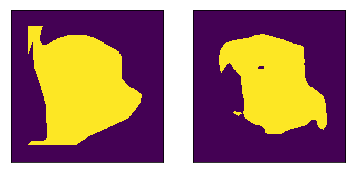

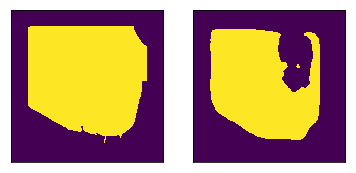

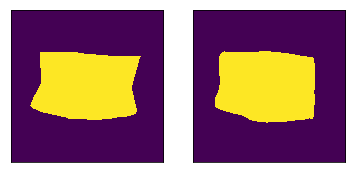

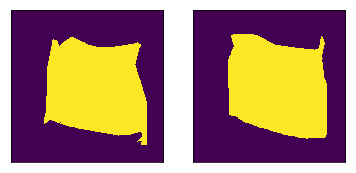

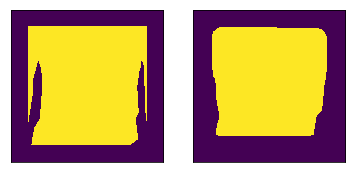

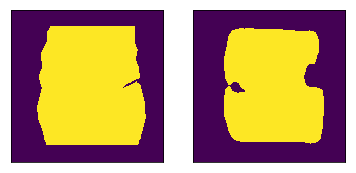

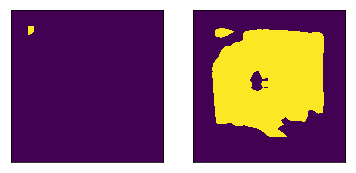

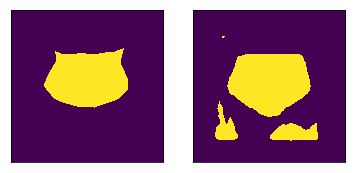

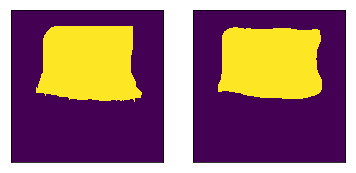

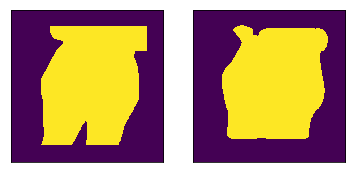

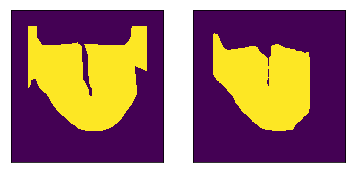

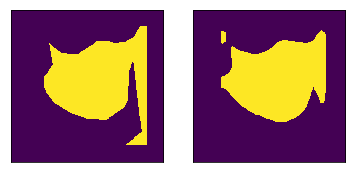

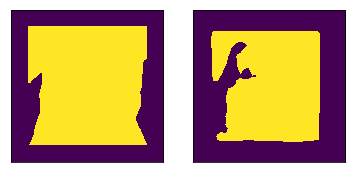

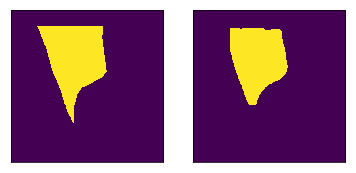

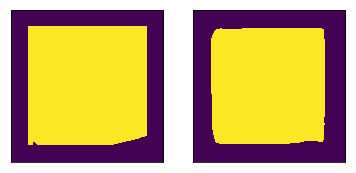

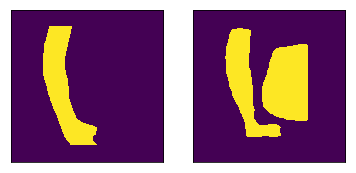

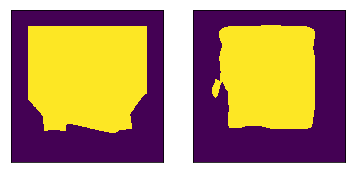

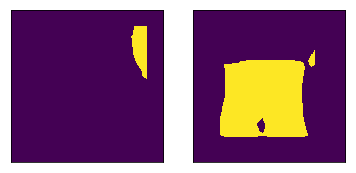

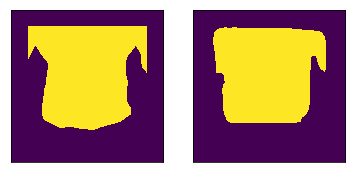

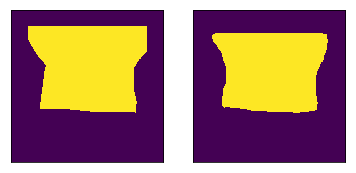

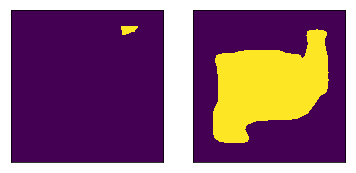

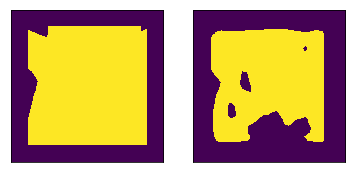

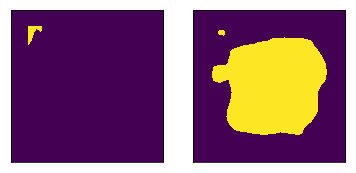

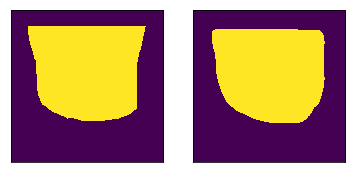

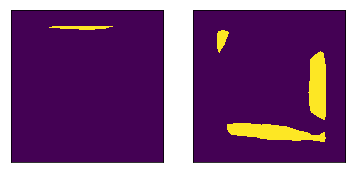

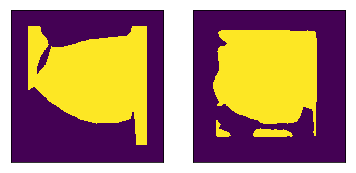

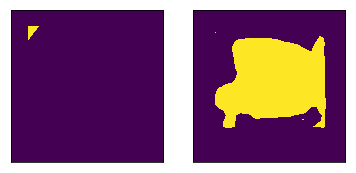

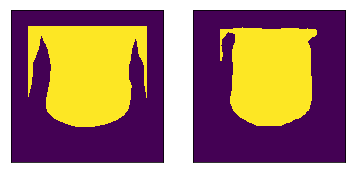

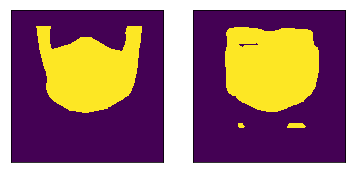

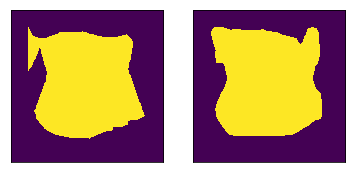

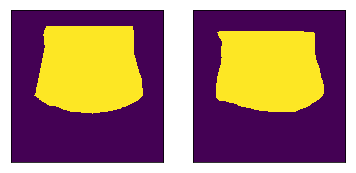

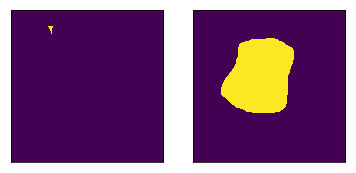

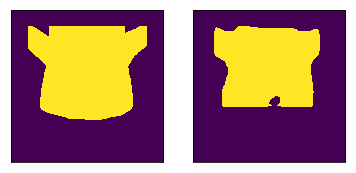

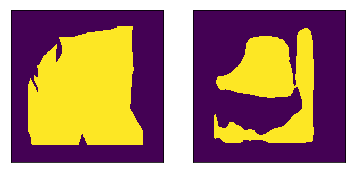

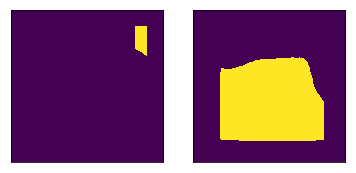

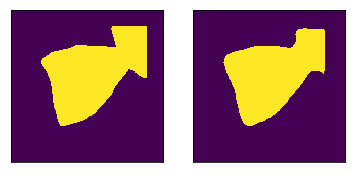

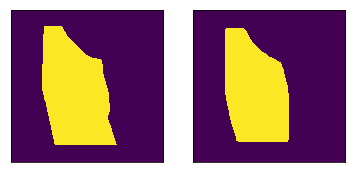

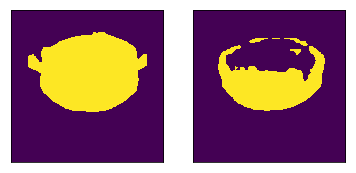

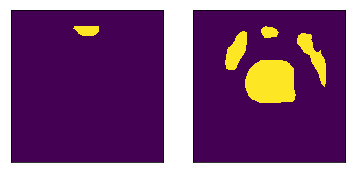

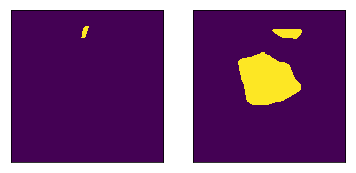

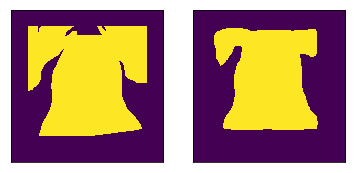

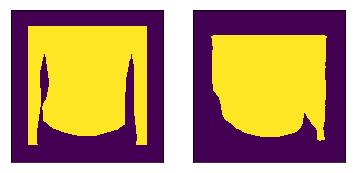

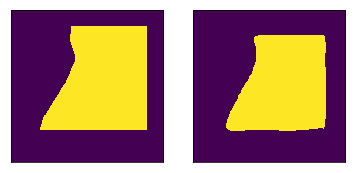

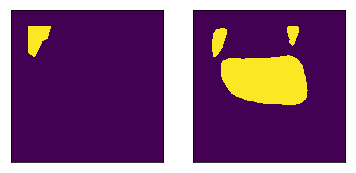

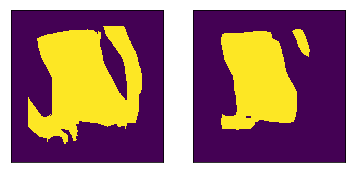

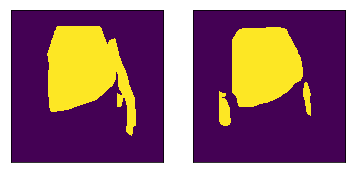

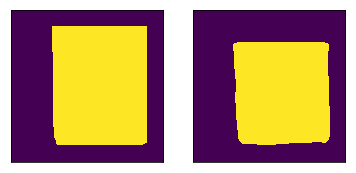

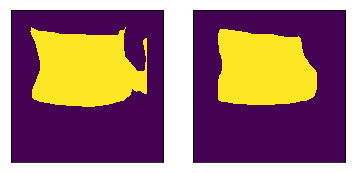

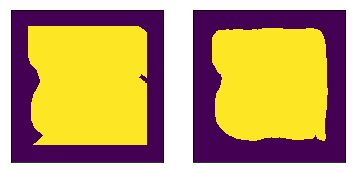

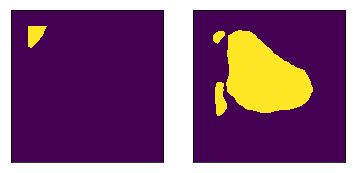

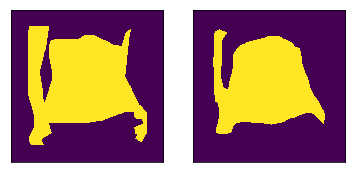

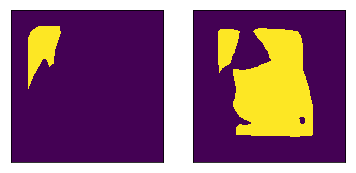

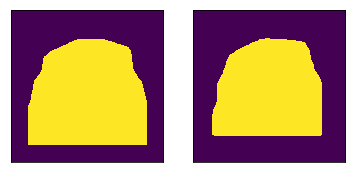

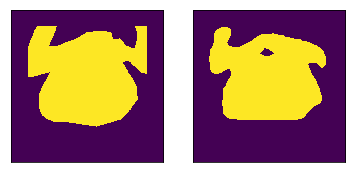

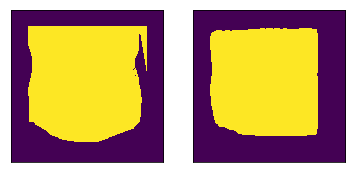

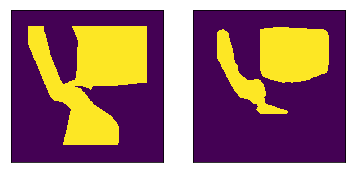

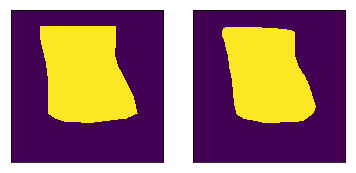

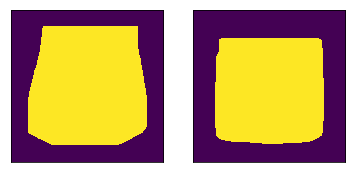

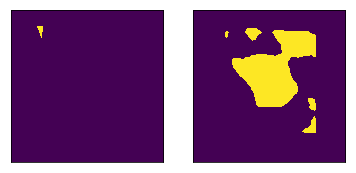

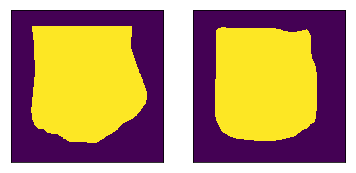

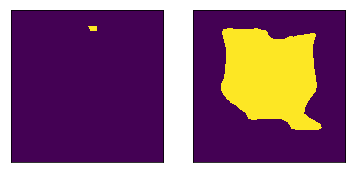

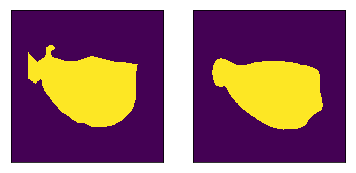

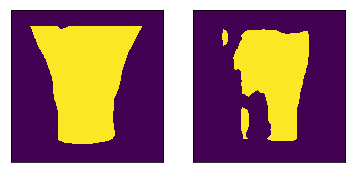

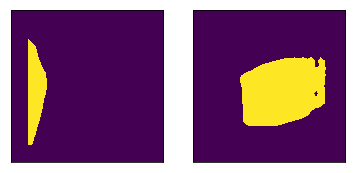

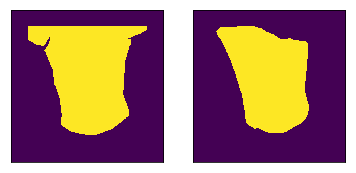

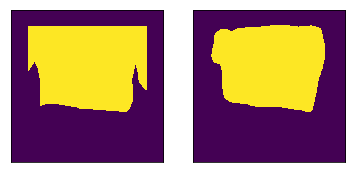

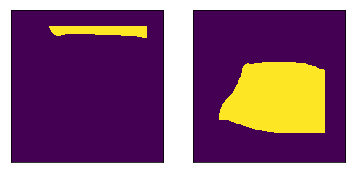

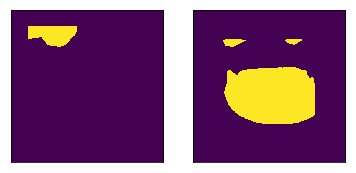

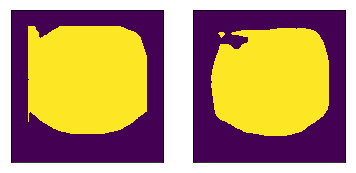

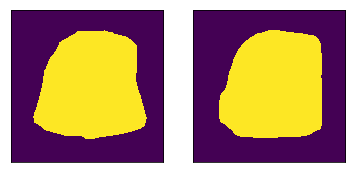

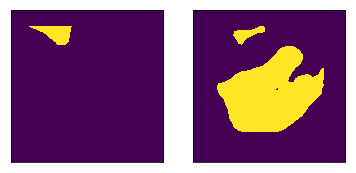

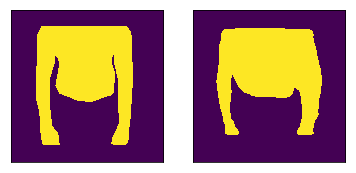

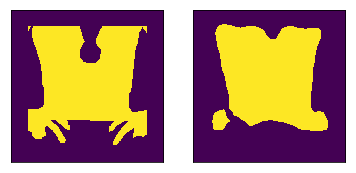

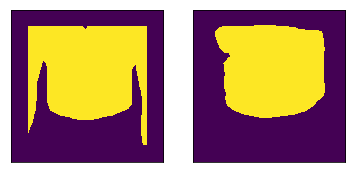

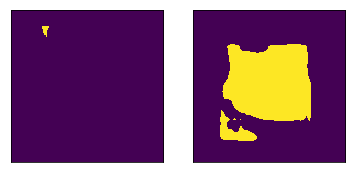

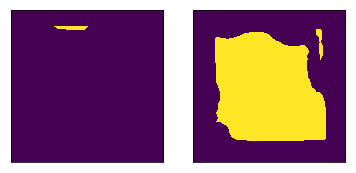

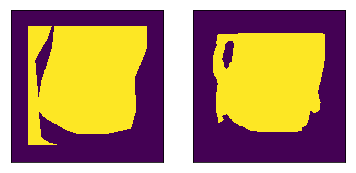

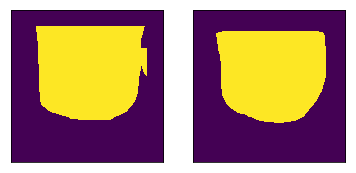

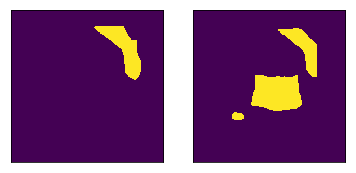

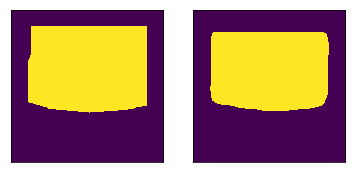

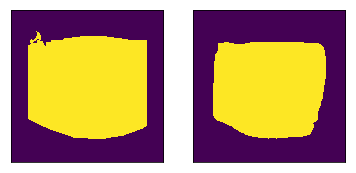

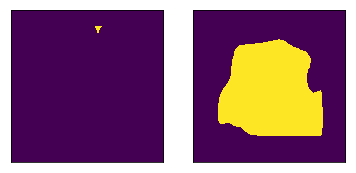

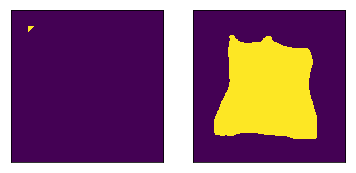

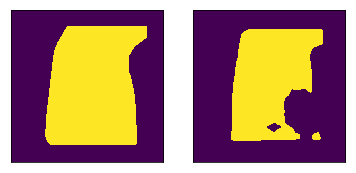

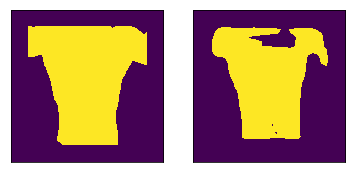

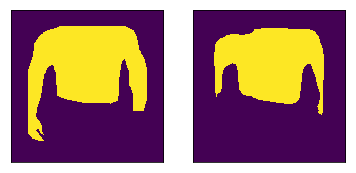

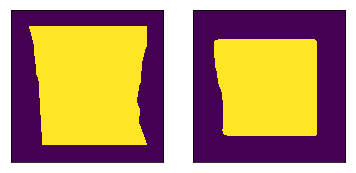

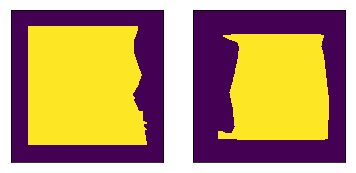

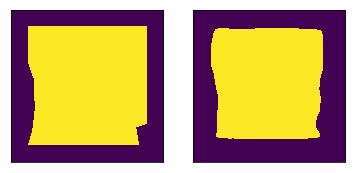

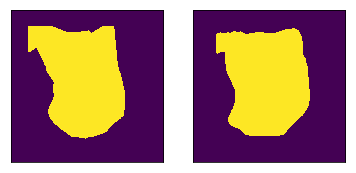

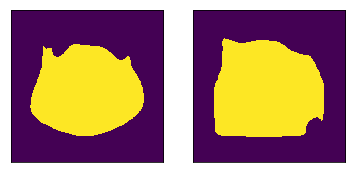

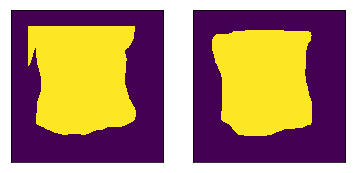

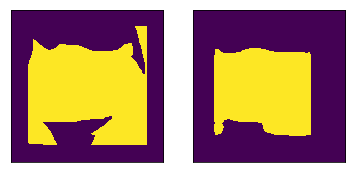

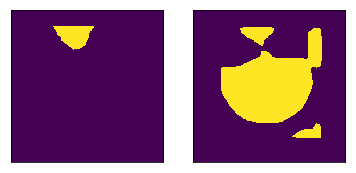

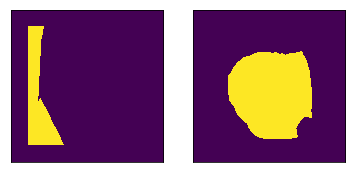

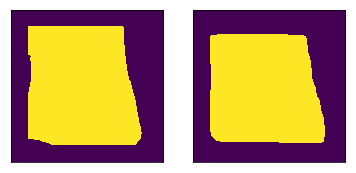

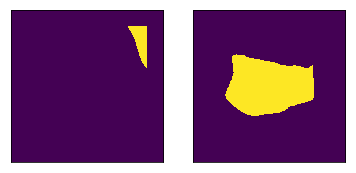

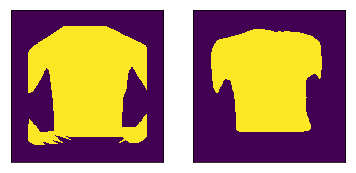

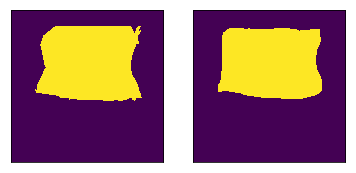

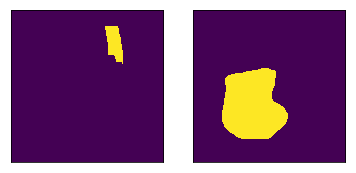

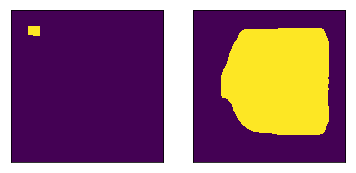

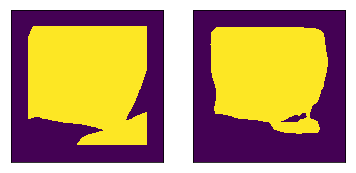

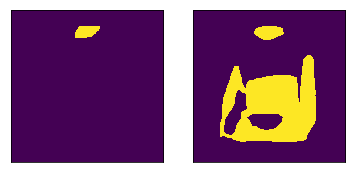

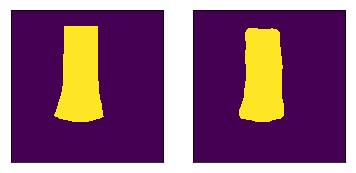

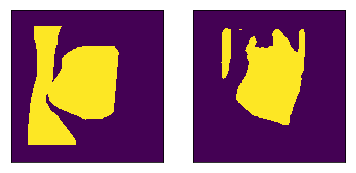

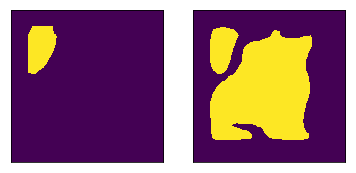

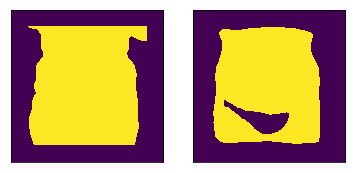

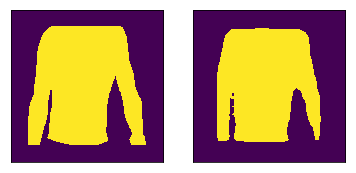

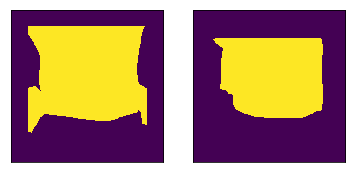

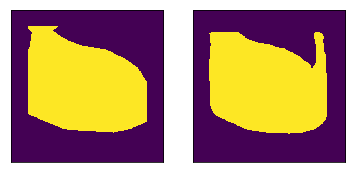

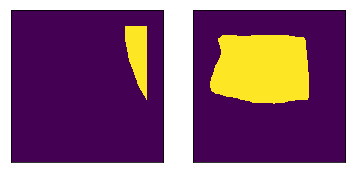

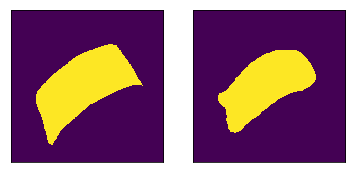

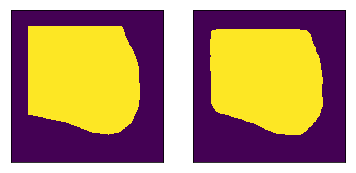

IndexError: list index out of range

In [56]:
import imshowpair
for i in range(0,266):
    imshowpair.imshowpair(msk[i],pred[i])
    plt.show()

## No predictions

In [ ]:
for i in range(0,c):
    plt.imshow(negimages[i])
    plt.show()